In [1]:
!pip install textract matplotlib

     |████████████████████████████████| 32.8 MB 31.2 MB/s 
     |████████████████████████████████| 8.9 MB 50.2 MB/s 
     |████████████████████████████████| 103 kB 90.2 MB/s 
     |████████████████████████████████| 97 kB 11.3 MB/s 
     |████████████████████████████████| 45 kB 7.5 MB/s 
     |████████████████████████████████| 111 kB 89.6 MB/s 
     |████████████████████████████████| 5.6 MB 35.3 MB/s 
     |████████████████████████████████| 145 kB 81.6 MB/s 
     |████████████████████████████████| 73 kB 5.3 MB/s 
     |████████████████████████████████| 112 kB 89.4 MB/s 
     |████████████████████████████████| 1.9 MB 67.7 MB/s 
  Created wheel for python-pptx: filename=python_pptx-0.6.18-py3-none-any.whl size=275704 sha256=16e0a578f8814aa4eba8f0057801b6327c1303c48101df1364b49a1abf38209c
  Stored in directory: /root/.cache/pip/wheels/68/99/55/8f6d0c128a214c26ac5b9f75ea68f6387feec407055458af1e
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3966 sha256=a6e3e70afcd

In [2]:
import textract
import os
import pandas as pd
import matplotlib.pyplot as plt
import string
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [3]:
# read pdf as text
new_dict = {}
for filename in os.listdir("new"):
    new_dict[int(filename.split(".")[0])] = textract.process(os.path.join("new", filename)).decode("utf-8")

old_dict = {}
for filename in os.listdir("old"):
    old_dict[int(filename.split(".")[0])] = textract.process(os.path.join("old", filename)).decode("utf-8")

In [4]:
# clean data to make cs only
for year in list(old_dict.keys()):
    first = old_dict[year].index('Faculty of the ')
    old_dict[year] = old_dict[year][first:]
    if 'Cross-listed Courses' in old_dict[year]:
        stop = old_dict[year].index('Cross-listed Courses')
        old_dict[year] = old_dict[year][:stop]

In [5]:
teachIndices = {}

old_start = 'log Number: '
old_end1 = '\nHalf course ('
old_end2 = '*Computer Science 3'

for year in range(1999,2015):
    text = old_dict[year]
    gradcut = text.index('Graduate Courses of Reading and Research')
    ug_info = text[:gradcut]
    grad_info = text[gradcut:]

    ug1 = [i+len(old_start) for i in range(len(ug_info)) if ug_info.startswith(old_start, i)]
    ug2 = [j for j in range(len(ug_info)) if ug_info.startswith(old_end1, j)]

    grad1 = [i+len(old_start)+gradcut for i in range(len(grad_info)) if grad_info.startswith(old_start, i)]
    grad2 = [j+gradcut for j in range(len(grad_info)) if grad_info.startswith(old_end2, j)][1:] + [len(text)]
    # when grad course has a description
    gradExtra = [j+gradcut for j in range(len(grad_info)) if grad_info.startswith(old_end1, j)]

    for i in range(len(grad2)-1,0,-1):
        if len(gradExtra) == 0:
            break
        elif gradExtra[-1] > grad2[i]:
            grad2[i+1] = gradExtra[-1]
            del gradExtra[-1]

    indices1 = ug1 + grad1
    indices2 = ug2 + grad2

    teachIndices[year] = {'start': indices1, 'end': indices2}

In [6]:
def noMidInit(name):
    if name.count(' ') > 1:
        spaces = [i for i in range(len(name)) if name[i] == ' ']
        name = name[:spaces[0]] + name[spaces[1]:]
    return name

In [7]:
names = {}
totalnames = {}

#includes all faculty who taught a class that academic year under cs dept, including grad courses, visiting profs,
#profs who only taught for one sem, etc
for year in range(1999,2015):
    text = old_dict[year]
    indices = teachIndices[year]
    namelist = []
    for i in range(len(indices['start'])):
        name = text[indices['start'][i]+4:indices['end'][i]].strip()
        if not ('------' in name or len(name) < 3 or 'Instructor to be determined' in name):
            if len(name) > 11:
                if name[:11] == 'Enrollment:':
                    newlinechar = name.index('\n')
                    name = name[newlinechar+1:]
            
            if name[0] in string.digits or name[1] in string.digits:
                newlinechar = name.index('\n')
                name = name[newlinechar+1:]

            if name[-1] in string.digits or name[-2] in string.digits:
                digitchar = min([name.index(str(i)) for i in range(10) if str(i) in name])
                name = name[:digitchar].strip()
            
            if ' and ' in name:
                if ',' not in name:
                    splitter = name.index(' and ')
                    first = name[:splitter]
                    second = name[splitter+5:]
                    if '(' in first:
                        paren = first.index('(')
                        first = first[:paren-1]
                    namelist.append(noMidInit(first))

                    # if '(' in second:
                    #     paren = second.index('(')
                    #     second = second[:paren-1]
                    if second.count(' ') > 1 + second.count('.'):
                        spacechar = [i for i in range(len(second)) if second[i] == ' '][1+second.count('.')]
                        second = second[:spacechar]
                    if second != 'members of':
                        if 'Zittrain' in second:
                            second = 'Jonathan Zittrain'
                        namelist.append(noMidInit(second))                        
                    continue
                else:
                    commanames = ['Yochai Benkler', 'Terry Fisher', 'Urs Gasser', 'Lawrence Lessig', 
                    'Phil Malone', 'Charles Nesson', 'John Palfrey', 'Jonathan Zittrain']
                    for person in commanames:
                        namelist.append(person)
                    continue

            if '(' in name:
                paren = name.index('(')
                if name[paren-2] in string.digits:
                    paren -= 2
                name = name[:paren-1]

            if 'Previous Courses' in name:
                xc = name.index('Previous') - 11
                tion = name.index('Previous') + 31
                name = name[:xc] + name[tion:]
                name = name.strip()

            if 'concentrators' in name:
                conc = name.index('concentrators')
                nl = name[conc:].index('\n')
                name = name[conc+nl:].strip()
            
            if name[-1] in string.digits:
                digitchar = min([name.index(str(i)) for i in range(10) if str(i) in name])
                name = name[:digitchar].strip()

            if name[0] in string.digits:
                name = name[4:].strip()

            if 'Zittrain' in name:
                name = 'Jonathan Zittrain'           

            namelist.append(noMidInit(name))
        
    names[year] = list(set(namelist))
    totalnames[year] = namelist

In [8]:
newindices = {}

for year in range(2015,2021):
    txt = new_dict[year]
    lognum = [m.end() for m in re.finditer('\([0-9]{6,7}\)', txt)]
    sem = [m.start() for m in re.finditer('\sCredits\)', txt)]
    data = {'start': lognum, 'end': sem}
    newindices[year] = data

In [9]:
for year in range(2015,2021):
    allnames = []

    txt = new_dict[year]
    data = newindices[year]

    for i in range(len(data['start'])):
        testname = txt[data['start'][i]:data['end'][i]-14].strip()
        if 'HARVARD' in testname:
            harvard = testname.index('HARVARD')
            page = testname.index('Page ')
            testname = testname[:harvard] + testname[page+16:]
            testname = testname.strip()
        if 'Value(s)' in testname:
            if testname.index('Value(s)') == 0:
                nl = max([i for i in range(len(testname)) if testname[i] == '\n'])
                testname = testname[nl:].strip()
            else:
                val = testname.index('Value(s)')
                testname = testname[:val-1].strip()
            if 'Page' in testname[:5]:
                testname = testname[15:]
        if '\x0c' in testname:
            newpage = testname.index('\x0c')
            first = testname[:newpage]
            second = testname[newpage+1:]
            testname = first.strip() + '\n' + second.strip()
        if '\n' in testname:
            # print('-' + testname)
            if '\n\n' not in testname:
                while '\n' in testname:
                    nl = testname.index('\n')
                    if len(testname[:nl]) > 6:
                        allnames.append(noMidInit(testname[:nl].strip()))
                    testname = testname[nl:].strip()
                allnames.append(noMidInit(testname))
                continue

        testname = testname.strip()
        testname = noMidInit(testname)
        
        allnames.append(testname)

    names[year] = list(set(allnames))
    totalnames[year] = allnames

In [58]:
# setting up the facultydata dictionary
masterNameList = [] # all names across all years, no duplicates
for year in range(1999,2021):
    masterNameList += totalnames[year]

masterNameList = list(set(masterNameList))

facultydata = {}

for name in masterNameList:
    facultydata[name] = {'total': 0}
    for year in range(1999,2021):
        facultydata[name][year] = 0

for year in range(1999,2021):
    for name in totalnames[year]:
        facultydata[name][year] += 1

for name in masterNameList:
    for year in range(1999,2021):
        facultydata[name]['total'] += facultydata[name][year]

for name in masterNameList:
    if facultydata[name]['total'] > 20 and facultydata[name][2006] + facultydata[name][2007] == 0:
        print(name)

Krzysztof Gajos
Finale Doshi-Velez
Yiling Chen
James Mickens
Stephen Chong
Yaron Singer
Eddie Kohler
Stratos Idreos
Jelani Nelson
Boaz Barak


In [51]:
faculty_count = {}
for year in range(1999,2021):
    faculty_count[year] = len(names[year])

faculty_inc = []
for year in range(2000,2021):
    pctinc = {}
    pctinc['year'] = year
    pctinc['change'] = (faculty_count[year] - faculty_count[year-1])/faculty_count[year-1] * 100
    faculty_inc.append(pctinc)

df_facinc = pd.DataFrame(faculty_inc)

Graphs

In [19]:
# colors
monochrome_colors = ['#251616', '#760000', '#C63F3F', '#E28073', '#F1D3CF']
primary_colors = ['#C63F3F', '#F4B436', '#83BFCC', '#455574', '#E2DDDB']

In [20]:
# template
theme_hodp = go.layout.Template(
    layout=go.Layout(
        title = {'font':{'size':24, 'family':"Helvetica", 'color':monochrome_colors[0]}, 'pad':{'t':100, 'r':0, 'b':0, 'l':0}},
        font = {'size':18, 'family':'Helvetica', 'color':'#717171'},
        xaxis = {'ticks': "outside",
                'tickfont': {'size': 14, 'family':"Helvetica"},
                'showticksuffix': 'all',
                'showtickprefix': 'last',
                'showline': True,
                'title':{'font':{'size':18, 'family':'Helvetica'}, 'standoff':20},
                'automargin': True
                },
        yaxis = {'ticks': "outside",
                'tickfont': {'size': 14, 'family':"Helvetica"},
                'showticksuffix': 'all',
                'showtickprefix': 'last',
                'title':{'font':{'size':18, 'family':'Helvetica'}, 'standoff':20},
                'showline': True,
                'automargin': True
                },
        legend = {'bgcolor':'rgba(0,0,0,0)', 
                'title':{'font':{'size':18, 'family':"Helvetica", 'color':monochrome_colors[0]}}, 
                'font':{'size':14, 'family':"Helvetica"}, 
                'yanchor':'bottom'
                },
        colorscale = {'diverging':monochrome_colors},
        coloraxis = {'autocolorscale':True, 
                'cauto':True, 
                'colorbar':{'tickfont':{'size':14,'family':'Helvetica'}, 'title':{'font':{'size':18, 'family':'Helvetica'}}},
                }
    )
)

In [21]:
# Faculty Number Line Plot
faculty = facultydata
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(faculty_count.keys()),
    y=list(faculty_count.values()),
    name='CS',
    mode='lines+markers',
    marker_color=primary_colors[0],
))

fig.update_layout(title="Number of Faculty Members per year", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Faculty Members'}}, 
                template=theme_hodp)
                
fig.show()

In [22]:
# CLASS MEETING TIMES
times = {}
days = {}
for year in range(1999,2015):
    text = old_dict[year]
    start_indices = [m.end() for m in re.finditer(" term\).", text)][1:]
    end_indices = [m.end() for m in re.finditer(r"[0-9]\.", text)]
    j = 0
    lst = []
    for i in range(len(end_indices)):
        if j >= len(start_indices) - 1:
            break
        if end_indices[i] - start_indices[j] <= 50 and end_indices[i] - start_indices[j] >= 4:
            if not 'Computer Science' in text[start_indices[j]:end_indices[i]]:
                lst.append(text[start_indices[j]:end_indices[i]])
                j += 1
        if end_indices[i] - start_indices[j] >= 50:
            j += 1
    times[year] = lst
    # print(times[year])

for year in range(2015, 2021):
    text = new_dict[year]
    start_indices = [m.end() for m in re.finditer("Schedule:", text)]
    end_indices = [m.start() for m in re.finditer("Enrollment Cap:", text)]
    lst = []
    bad_strings = ["TBD", "1/24/2019", "Page", "Instructor", "HARVARD UNIVERS", "An introdu", "Enroll", "3/31/2021"]
    dictionary = {'M': 0, 'T': 0, 'W': 0, 'R': 0,'F': 0}
    for i in range(len(end_indices)):

        check_string = text[start_indices[i] + 19: start_indices[i] + 40]
        if not any(string in check_string for string in bad_strings):
            lst.append((check_string).rstrip())
            if 'M' in check_string:
                dictionary['M'] += 1
            if 'T' in check_string:
                dictionary['T'] += 1
            if 'W' in check_string:
                dictionary['W'] += 1
            if 'R' in check_string:
                dictionary['R'] += 1
            if 'F' in check_string:
                dictionary['F'] += 1

    times[year] = lst

    days[year] = dictionary
print(days)



{2015: {'M': 49, 'T': 30, 'W': 15, 'R': 29, 'F': 7}, 2016: {'M': 42, 'T': 24, 'W': 14, 'R': 24, 'F': 3}, 2017: {'M': 53, 'T': 26, 'W': 22, 'R': 26, 'F': 7}, 2018: {'M': 54, 'T': 23, 'W': 23, 'R': 22, 'F': 8}, 2019: {'M': 53, 'T': 19, 'W': 28, 'R': 19, 'F': 9}, 2020: {'M': 47, 'T': 24, 'W': 21, 'R': 23, 'F': 5}}


In [23]:
# Class Meetings Bar Plot
fig = go.Figure(layout=go.Layout(barmode='stack'))
buttons = []
fig.add_trace(go.Bar(
        x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        y=list(days[2020].values()),
        marker_color=primary_colors[-1],
        name='',
        visible=True
    ))
buttons.append(dict(args=[{'visible': [True, False, False, False, False, False]}], label="2020",method="update"))
count = 1
for year in reversed(range(2016,2020)):
    bools = [False] * 6
    bools[count] = True
    buttons.append(dict(args=[{'visible': bools}],
                    label=str(year),
                    method="update"))
    count += 1
    fig.add_trace(go.Bar(
        x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        y=list(days[year].values()),
        marker_color=primary_colors[year%4],
        name='',
        visible=False
    ))

fig.update_layout(title="Distribution of CS Classes over Days of the Week", 
                xaxis={'title':{'text':'Day'}}, 
                yaxis={'title':{'text':'Number of Classes'}}, 
                template=theme_hodp)


fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            x=-.1,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)
                

fig.show()

In [56]:
# faculty total changes
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_facinc['year'],
    y=df_facinc['change'],
    name='CS',
    marker_color=primary_colors[3],
))

fig.update_layout(title="Percentage Change in CS Faculty", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Percent Change'}}, 
                template=theme_hodp)
                
fig.show()

In [57]:
# Faculty Member Influence 
# Faculty Number Line Plot
import collections
faculty_dict = collections.OrderedDict(sorted(facultydata.items()))
faculty = list(faculty_dict.keys())
dropdown = []
fig = go.Figure()
for i, member in enumerate(faculty):
    if faculty_dict[member]['total'] > 20:
        bool_list = [False] * len(faculty)
        bool_list[i] = True
        dropdown.append(dict(
                        args=[{'visible': bool_list}],
                        label=member,
                        method="update"
                        ))

    fig.add_trace(go.Scatter(
        x=list(faculty_count.keys()),
        y=list(faculty_dict[member].values())[1:],
        name='CS',
        mode='lines+markers',
        marker_color=primary_colors[0],
        visible = (member == "Avrom Pfeffer")
))


fig.update_layout(title="Number of CS Teacher Name Mentions in Course Catalog over Time", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Mentions'}},
                template=theme_hodp_ticks)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown,
            direction="down",
            showactive=True,
            x=-.1,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)
                
fig.show()

In [70]:
# count number of classes
classes = {}
for year in range(1999,2015):
    classes[year] = old_dict[year].count("log Number:") + old_dict[year].count("repeated spring term)")

for year in range(2015,2021):
    classes[year] = new_dict[year].count("Instructor Permissions")

In [71]:
# classes plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(classes.keys()),
    y=list(classes.values()),
    name='CS',
    mode='lines+markers',
    marker_color=primary_colors[0],
))

fig.update_layout(title="Number of CS Class Offerings by year", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Classes'}}, 
                template=theme_hodp)
                
fig.show()

In [65]:
# fall or spring
semester = []
old_types = ["fall term", "spring term"]
new_types = ["Fall (4 Credits)", "Spring (4 Credits)"]
for year in range(1999,2015):
    data = {}
    data['year'] = year
    data['fall'] = old_dict[year].count(old_types[0])
    data['spring'] = old_dict[year].count(old_types[1])
    semester.append(data)

for year in range(2015,2021):
    data = {}
    data['year'] = year
    data['fall'] = new_dict[year].count(new_types[0])
    data['spring'] = new_dict[year].count(new_types[1])
    semester.append(data)

df_semester = pd.DataFrame(semester)
df_semester

In [66]:
# classes plot for semester
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(df_semester['year']),
    y=list(df_semester['fall']),
    name='Fall',
    mode='lines+markers',
    marker_color=primary_colors[2],
))
fig.add_trace(go.Scatter(
    x=list(df_semester['year']),
    y=list(df_semester['spring']),
    name='Spring',
    mode='lines+markers',
    marker_color=primary_colors[1],
))

fig.update_layout(title="Number of CS Class Offerings by semester", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Classes'}}, 
                template=theme_hodp)
                
fig.show()

In [35]:
# CS Degrees Awarded
male_degrees = {2009: 83, 2010: 84, 2011: 114, 2012: 149, 2013: 195, 2014: 206, 2015: 262 , 2016: 296, 2017: 324, 2018: 325, 2019: 339}
female_degrees = {2009: 10, 2010: 25, 2011: 42, 2012: 66, 2013: 79, 2014: 89, 2015: 87, 2016: 114, 2017: 127, 2018: 145, 2019: 164}
#total = {x: male_degrees.get(x, 0) + female_degrees.get(x, 0) for x in set(male_degrees)}

degrees = []

for year in list(male_degrees.keys()):
    data = {'year': year, 'male': male_degrees[year], 'female': female_degrees[year]}
    totalppl = male_degrees[year] + female_degrees[year]
    malepct = male_degrees[year]/totalppl * 100
    fempct = female_degrees[year]/totalppl * 100
    data['malepct'] = malepct
    data['fempct'] = fempct
    degrees.append(data)

df_degrees = pd.DataFrame(degrees)

In [36]:
fig = go.Figure(layout=go.Layout(barmode='stack'))


fig.add_trace(go.Bar(
    x=df_degrees['year'],
    y=df_degrees['male'],
    name='Male',
    marker_color=primary_colors[2],
))
fig.add_trace(go.Bar(
    x=df_degrees['year'],
    y=df_degrees['female'],
    name='Female',
    marker_color=primary_colors[0],
))


fig.update_layout(title="CS Concentrators by Gender per year", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Students'}}, 
                legend={'title':{'text':'Gender'}},
                template=theme_hodp)

fig.show()

In [37]:
# stacked area chart by gender
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_degrees['year'], 
    y=df_degrees['malepct'],
    mode='lines',
    name='Male',
    line=dict(width=0.5, color=primary_colors[2]),
    marker_color=primary_colors[2],
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=df_degrees['year'], 
    y=df_degrees['fempct'],
    mode='lines',
    name='Female',
    line=dict(width=0.5, color=primary_colors[0]),
    marker_color=primary_colors[0],
    stackgroup='one' # define stack group
))

fig.update_layout(title="Proportion of CS Concentrators by Gender per year", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Students'}}, 
                legend={'title':{'text':'Gender'}},
                yaxis_range=(0,100),
                template=theme_hodp)
fig.show()

Types of classes (unsure if use)

In [ ]:
descriptions = {}
for year in range(1999,2015):
    descriptions[year] = old_dict[year].split("log Number:")
for year in range(2015,2021):
    descriptions[year] = new_dict[year].split("log Number:")

# count instance of machine learning
machine_learning = {}
for year in range(1999,2015):
    machine_learning[year] = old_dict[year].count("achine Learning") + old_dict[year].count("achine learning")

for year in range(2015,2021):
    machine_learning[year] = new_dict[year].count("achine Learning") + new_dict[year].count("achine learning")

descriptions

{1999: ['Faculty of the Division of Engineering and Applied Sciences Offering Instruction in \nComputer Science \n\nMichael S. Brandstein, Assistant Professor of Electrical Engineering on the Gordon McKay \nEndowment \nUgo O. Gagliardi, Gordon McKay Professor of the Practice of Computer Engineering \nSteven J. Gortler, Assistant Professor of Computer Science on the Gordon McKay Endowment \n(Director of Undergraduate Studies) \nBarbara J. Grosz, Gordon McKay Professor of Computer Science \nH. T. Kung, William H. Gates Professor of Computer Science and Electrical Engineering \nHenry H. Leitner, Senior Lecturer on Computer Science \nHarry R. Lewis, Gordon McKay Professor of Computer Science and Dean of Harvard College \nMichael D. Mitzenmacher, Assistant Professor of Computer Science on the Gordon McKay \nEndowment \nVenkatesh Narayanamurti, John A. and Elizabeth S. Armstrong Professor of Engineering and \nApplied Sciences (Dean of the Division of Engineering and Applied Sciences) \nAntho

In [ ]:
# count instance of artificial intelligence
ai = {}

for year in range(1999,2015):
    ai[year] = old_dict[year].count("rtificial intelligence") + old_dict[year].count("rtificial Intelligence")


for year in range(2015,2021):
    ai[year] = new_dict[year].count("rtificial intelligence") + new_dict[year].count("rtificial Intelligence")
ai


{1999: 1,
 2000: 2,
 2001: 2,
 2002: 2,
 2003: 2,
 2004: 2,
 2005: 2,
 2006: 3,
 2007: 4,
 2008: 3,
 2009: 3,
 2010: 1,
 2011: 1,
 2012: 3,
 2013: 3,
 2014: 3,
 2015: 2,
 2016: 4,
 2017: 5,
 2018: 3,
 2019: 4,
 2020: 7}

In [ ]:
network = {}

for year in range(1999,2015):
    ai[year] = old_dict[year].count("rtificial intelligence") + old_dict[year].count("rtificial Intelligence")


for year in range(2015,2021):
    ai[year] = new_dict[year].count("rtificial intelligence") + new_dict[year].count("rtificial Intelligence")
ai

In [ ]:
#AI and ML plots
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(machine_learning.keys()),
    y=list(machine_learning.values()),
    name='Machine Learning',
    mode='lines+markers',
    marker_color=primary_colors[0],
))
fig.add_trace(go.Scatter(
    x=list(ai.keys()),
    y=list(ai.values()),
    name='Artificial Intelligence',
    mode='lines+markers',
    marker_color=primary_colors[2],
))

fig.update_layout(title="Number of CS Classes with certain keywords in the class descriptions", 
                xaxis={'title':{'text':'Year'}}, 
                yaxis={'title':{'text':'Number of Classes'}}, 
                legend={'title':{'text':'Keywords'}},
                template=theme_hodp)
                
fig.show()

In [ ]:
# count instance of David Malan
god = {}
for year in range(1999,2015):
    god[year] = old_dict[year].count("Malan") + old_dict[year].count("achine learning")

for year in range(2015,2021):
    god[year] = new_dict[year].count("Malan") + new_dict[year].count("achine learning")

god

{1999: 0,
 2000: 1,
 2001: 1,
 2002: 1,
 2003: 1,
 2004: 1,
 2005: 1,
 2006: 1,
 2007: 3,
 2008: 3,
 2009: 3,
 2010: 3,
 2011: 5,
 2012: 5,
 2013: 9,
 2014: 6,
 2015: 8,
 2016: 8,
 2017: 19,
 2018: 15,
 2019: 13,
 2020: 19}

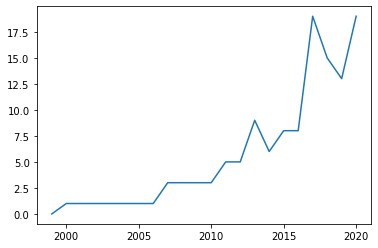

In [ ]:
#god plot
plt.plot(god.keys(), god.values())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=782170b4-2083-4d4e-9662-39a79aea6d19' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>